#Retrieval Augmented Generation Pipeline
The notebook is organized as follows:

1. Set-Up

2. RAG components

  2.1  Text Chunking  
  2.2  Text Embeddings  
  2.3  Vector Database & Semantic Search  
  2.4  The Large Language Model   
  2.5  Testing the LLM in a LangChain Chain   
  2.6. Setting up a simple RAG Chain     

      
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2024-fall-main/blob/master/materials/lesson_notebooks/lesson_10_RAG.ipynb)

**To run this notebook** click the button that opens it in Colab. Note it needs a T4 GPU to run.  


##1. Setup

Install the libraries and import necessary packages.  We'll make extensive use of a framework named [LangChain](https://python.langchain.com/v0.3/docs/introduction/) that makes it easier to experiment with the different components of a RAG pipeline.






In [1]:
%%capture
#!pip -q install git+https://github.com/huggingface/transformers



!pip -q install bitsandbytes accelerate
!pip -q install langchain
!pip install einops

!pip install --upgrade --quiet  langchain-community qdrant-client

!pip install langchainhub

!pip install -U langchain-huggingface

!pip install --upgrade --quiet  arxiv
!pip install --upgrade --quiet  pymupdf



In [2]:
import torch
import os
import json
import numpy as np
import time


from pprint import pprint

import locale

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline, BitsAndBytesConfig

from langchain_huggingface import HuggingFacePipeline


from langchain import PromptTemplate, LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Qdrant
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.utils.math import cosine_similarity

from langchain_community.document_loaders import ArxivLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import OnlinePDFLoader
from langchain_community.document_loaders import PyMuPDFLoader

from google.colab import userdata

In [3]:
locale.getpreferredencoding = lambda: "UTF-8"

In [4]:
# We'll need an embedding engine and the sentence transformers library provides that

%%capture
!pip install sentence_transformers

##2. Building the Components of our RAG System

A basic RAG system consists of a set of base components. There's a query. There's a set of documnets stoed in an indexing system that relies on an embedding engine.  Finally we use an LLM to generate answers to the question using the content we retreive from the indexing system based on the query. We will use the Hugging Face, LangChain, and sentence transformers libraries to implement our system in this notebook.

Study the diagram below to understand the overall flow of the pipeline we need to instantiate.  This will help contextualize what we are doing as we build up the components of the pipeline.

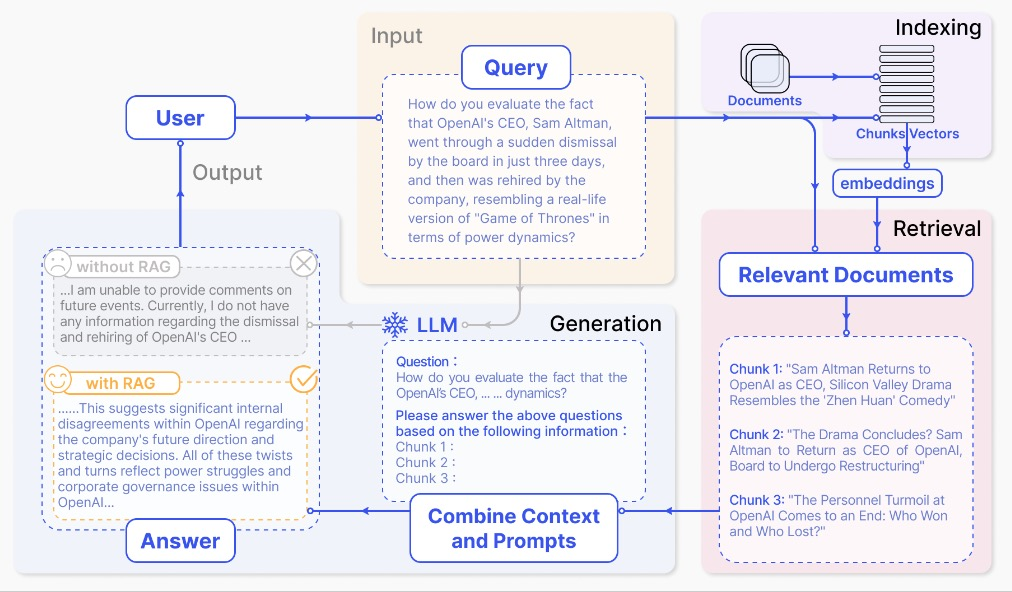

Image Source: [Retrieval-Augmented Generation for Large
Language Models: A Survey](https://arxiv.org/pdf/2312.10997), Gao et. al., 2024

To complete our RAG system, we'll need:
  1. a collection of documents
  2. a document chunker to split our docs into pieces
  3. an embedding model to convert our pieces in vectors
  4. a vector store to store our embeddings and make them searchable
  5. a pipeline to query our vector store and create a context bundle
  6. an LLM to use the context bundle and a prompt to generate an answer



###2.1. Loading the documents and chunking the texts

We first need to load the documents. We are going to grab three papers related to retrieval augmented generation off of arxiv.
We can then ask the papers questions. We'll make use of LangChain's Document Loaders class, in this case the loader for arxiv.


In [5]:
global_doc_number = 1

Here are the three papers we're loading in to our document/vector store

[Retrieval-Augmented Generation for Large
Language Models: A Survey](https://arxiv.org/pdf/2312.10997.pdf)

[Retrieval-Augmented Generation for Natural Language
Processing: A Survey](https://arxiv.org/pdf/2407.13193.pdf)

[CRAG - Comprehensive RAG Benchmark](https://arxiv.org/pdf/2406.04744.pdf)

We can ask questions of these three papers.  
*(You can experiment with others outside of class)*.

In [6]:
arxiv_numbers = ('2312.10997', '2407.13193', '2406.04744')

In [7]:
all_arxiv_pages = []

#loop through the papers
for identifier in arxiv_numbers:
    # Construct URL using the arXiv unique identifier
    arx_url = f"https://arxiv.org/pdf/{identifier}.pdf"

    # Extract pages from the document and add them to the list of pages
    arx_loader = PyMuPDFLoader(arx_url)
    arx_pages = arx_loader.load()
    for page_num in range(len(arx_pages)):
        page = arx_pages[page_num]
        page.metadata['page_num'] = page_num
        page.metadata['doc_num'] = global_doc_number
        page.metadata['doc_source'] = "ArXiv"
        all_arxiv_pages.append(page)


    global_doc_number += 1

How many docs did we get?  Is that the correct number? And what is the content that we've downloaded?

In [8]:
num_pages = len(all_arxiv_pages)
num_docs = global_doc_number - 1

print(f"{num_docs} documents in total")
print(f"{num_pages} pages in total")

3 documents in total
54 pages in total


In [9]:
all_arxiv_pages[2].page_content[:150]  # all pages of the Document content

'3\nFig. 2. A representative instance of the RAG process applied to question answering. It mainly consists of 3 steps. 1) Indexing. Documents are split '

Now we need to split the docs into chunks.  LangChain provides many ways to do that.  We'll use the `RecursiveCharacterTextSplitter`.  This class allows us to take a longer page and break it down in to pieces.  We can specify the size of those pieces which we call chunks.

We are splitting the text into chunks that are 'suitable' as retrieval units that we can arrange to construct our context bundle. For starters, let's define a chunk size of 256 and have an overlap of 56 between the chunks:  


In [10]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=256, chunk_overlap=56)
splits = text_splitter.split_documents(all_arxiv_pages)
print('Number of splits/chunks: ', str(len(splits)))

Number of splits/chunks:  1341


Ok, so it looks like we have now many splits (chunks) from one document. We can pick a chunk at random, by giving its relative index number. You can access the content of a chunk by looking at its page_content:

In [11]:
splits[1001].page_content
#splits[1000].metadata

'Knowledge Bases?. In Proceedings of the 2019 Conference on Empirical Methods\nin Natural Language Processing and the 9th International Joint Conference on\nNatural Language Processing (EMNLP-IJCNLP), Kentaro Inui, Jing Jiang, Vincent'

That looks reasonable for the contents of a chunk. Now we can turn to text embeddings to represent the chunks.

###2.2 The Embedding Model

We will need to represent text (pieces) as dense vectors. For this, we will use the sentence_transformer architecture and library.

**NOTE:** The sentence transformers library contains a wide variety of embeddng models. Here we'll use one of the higher scoring and faster models [according to this table](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models): `all-mpnet-base-v2`.



In [12]:
%%capture
base_embeddings = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")

Let's test two fake "documents" to make sure that the embedding engine works and returns vectors.  We can also test the vectors to make sure that semantically similiar vectors have a high cosine similarity and non-similiar vectors have a low cosine similarity score.

In [13]:
text = "This is a good day."
query_result = base_embeddings.embed_query(text)
print(f'Embedding dimension: {len(query_result)}')

doc_result = base_embeddings.embed_documents([text, "This is not a good day."])
len(doc_result)

Embedding dimension: 768


2

Okay, two vectors returned each of dimension 768.

In [14]:
#cosine simiarity of doc_result[0] and doc_result[1]
from numpy.linalg import norm

cos_sim = np.dot(doc_result[0], doc_result[1])/(norm(doc_result[0])*norm(doc_result[1]))

cos_sim

0.5228294955762047

Great, our two sentences yield vectors without a high cosine similariy reflecting that the sentences have opposite meanings.

Perfect. Now we have the splits and embeddings. Next, the embeddings need to be stored in a vector database.

###2.3 Storing the Embeddings of Chunks in Vectorstores

After loading and chunking the data, we need to save the vector representations of the chunks in a vectorstore. We will use Qdrant here for simplicity. We load the splits (structured chunks) and their embeddings:

In [15]:
vectorstore = Qdrant.from_documents(splits,
    base_embeddings,      #the embeddings model we just instantiated
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="test",
)
retriever = vectorstore.as_retriever()

The nice thing is that the vector store also does the similarity searches for us:

In [16]:
query = "What is the vector store doing?"
query_docs = vectorstore.similarity_search_by_vector(base_embeddings.embed_query(query)) # will rank the splits

In [17]:
query_docs

[Document(metadata={'source': 'https://arxiv.org/pdf/2407.13193.pdf', 'file_path': 'https://arxiv.org/pdf/2407.13193.pdf', 'page': 13, 'total_pages': 17, 'format': 'PDF 1.5', 'title': 'Retrieval-Augmented Generation for Natural Language Processing: A Survey', 'author': 'Shangyu Wu, Ying Xiong, Yufei Cui, Haolun Wu, Can Chen, Ye Yuan, Lianming Huang, Xue Liu, Tei-Wei Kuo, Nan Guan, and Chun Jason Xue', 'subject': '', 'keywords': '', 'creator': 'LaTeX with acmart 2020/02/22 v1.70 Typesetting articles for the Association for Computing Machinery and hyperref 2023-04-22 v7.00x Hypertext links for LaTeX', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20240722001339Z', 'modDate': 'D:20240722001339Z', 'trapped': '', 'page_num': 13, 'doc_num': 2, 'doc_source': 'ArXiv', '_id': '2126d8fda6c04d318430e2d9097c9048', '_collection_name': 'test'}, page_content='Ting Wang, Bo Tang, and Charles Xie. 2022. Manu: A Cloud Native Vector\nDatabase Management System. Proc. VLDB Endow. 15, 12 (2022), 3548–35

Looks good! We have an ordered list of documents that seem to relate to the question. That is what we need to build the special context bundle we'll ultimatly pass to the LLM.

The last major component is the actual LLM that we'll use to craft an answer to the incoming question.

###2.4. The LLM

We'll use a relatively new model for our LLM -- ([mistralai/Mistral-7B-Instruct-v0.2](https://huggingface.co/Mistral/Mistral-7B-Instruct-v0.2)).  We've commented out several open source model  for our tests that we've used in previous weeks. You can experiment with using it instead. We've also included a larger version of the Qwen2 model - [Qwen/Qwen2-7B-Instruct](https://huggingface.co/Qwen/Qwen2-7B-Instruct) and - [Google's Gemma2 2B](https://huggingface.co/google/gemma-2-2b-it).  One advantage to a framework like LangChain is that it lets you easily swap out components within the larger pipeline.  Let's set up the model:

In [20]:
%%capture
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         )
llm_mistral_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    #"Qwen/Qwen2-1.5B-Instruct",
    #"Qwen/Qwen2-7B-Instruct",
    #"google/gemma-2-2b-it",
    torch_dtype=torch.float32,
    device_map='auto',
    quantization_config=quantization_config
)

llm_mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
#llm_mistral_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-1.5B-Instruct")
#llm_mistral_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-7B-Instruct")
#llm_mistral_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

We use the model first to generate a Hugging Face pipeline. A pipeline simplifies the process of actually generating responses.

In [21]:
mistral_pipe = pipeline(
    "text-generation",
    model=llm_mistral_model,
    tokenizer=llm_mistral_tokenizer,
    max_new_tokens=768,
    truncation=True,
    temperature=0.6,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.2
)
mistral_pipe.model.config.pad_token_id = mistral_pipe.model.config.eos_token_id

Can we interact with LLM we've loaded?  Yes, we can go ahead and just ask it questions and have it generate answers independent of any retrieval.

In [22]:
mistral_pipe("[INST] User: Give me a two-sentence story about fine tuning of Large Language Models [/INST] Assistant: ")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': "[INST] User: Give me a two-sentence story about fine tuning of Large Language Models [/INST] Assistant: 1. After training a large language model on vast amounts of data, researchers meticulously fine-tuned its parameters to optimize its performance in specific tasks, enhancing its ability to generate accurate and contextually relevant responses.\n\n2. Through rigorous experimentation and adjustment, the team refined their large language model's settings, enabling it to excel in various applications such as text completion, translation, and question answering."}]

Note this isn't a story but more of an explanation.


###2.5 Testing the LLM in a LangChain Chain

Chains are convenient programmatic ways to deal with 'chains' of actions that involve LLMs. For example, a list of events like 'here is an object name. Plug that object name into prompt template, then generate a story about that object. Lastly, format the model output as a string' can be easily handled by LangChain's Chain framework. In the RAG case, the Chain would consist of the prompt template, the LLM, and the String Formatter. The parameter (the object in this case) will be provided at run time by invocation of the Chain. Let's test that.

To use a Hugging Face model in a LangChain environment, we need to wrap the model into a LangChain pipeline object:

In [23]:
mistral_llm_lc = HuggingFacePipeline(pipeline=mistral_pipe)

Next, we need to define a template and create a corresponding prompt template that can take some input and add that in to the prompt.

In [24]:
test_llm_template = """[INST] User: Give me a two-sentence story about an {object}! [/INST] Assistant: """
test_llm_prompt_template = PromptTemplate(template=test_llm_template, input_variables=["object"])



Let's define a Chain, a static flow of actions that (usually) involve at least a definition of the variables used in the chain, one or more templates, LLM step(s) and potentially other actions. This would be a chain that declares the variable 'object' to be expected when the chain is invoked, then inserts it into the template, and passes this to our mistral model pipeline (wrapped as a LangChain object):    

In [25]:
# wrapping the Hugging Face pipeline into a LangChain object
test_llm_chain_short = (
    {"object": RunnablePassthrough()}
    | test_llm_prompt_template
    | mistral_llm_lc
)

In [26]:
test_llm_chain_short.invoke('augmented retrieval')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'[INST] User: Give me a two-sentence story about an augmented retrieval! [/INST] Assistant:  In the bustling city of Neo-Tokyo, a brilliant inventor named Hideo unveiled his latest creation - an advanced AI system capable of instantaneous data retrieval. Amidst the crowd\'s applause, he queried, "What is the square root of pi to a thousand decimal places?" The AI answered in a heartbeat, revolutionizing information access forever.'

Works too. We will use this notation moving forward.

###2.6 Setting Up a Simple RAG Chain

For RAG, we will follow the same approach. Except... you will **later** need to change the chain to include the retrieval step.

We first do a simple test: create a RAG template that takes a question and a pre-defined context as input, and generates the answer based on the provided context:

In [27]:
output_parser = StrOutputParser()

In [28]:
rag_template = """[INST] Answer the question based only on the following context:
{context}

Question: {question}
[/INST]
Assistant:
"""
rag_prompt_template = ChatPromptTemplate.from_template(rag_template)

base_rag_chain =(
    {"context": RunnablePassthrough(),
     "question": RunnablePassthrough()}
    | rag_prompt_template
    | mistral_llm_lc
    | output_parser
)

predefined_context = "The first MIDS students were admitted in January 2014."
question = "When did the MIDS program begin?"

resp = base_rag_chain.invoke({'context': predefined_context,
                           'question': question})
print(resp)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Human: [INST] Answer the question based only on the following context:
{'context': 'The first MIDS students were admitted in January 2014.', 'question': 'When did the MIDS program begin?'}

Question: {'context': 'The first MIDS students were admitted in January 2014.', 'question': 'When did the MIDS program begin?'}
[/INST]
Assistant:
Based on the provided context, the answer to your question is January 2014.


Let's ask a different question but retreive some context out of our vector store.


The context needs to be created in an earlier retrieval step. More precisely, the documents will be first retrieved as a list, and then they will need to be formatted into one string to pass to the LLM in the context window.

Here is a simple formatting function that can be hooked into the chain, which combines a list of chunks into one string:



In [29]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

So how could we build a simple chain? Let's first just get the retrieval done and the formatted retrieved data and the question inserted into the prompt template:

In [30]:
rag_template = """[INST] Here is a context:\n{context} \n\nand here is a question: \n{question} [/INST] Assistant: """

rag_prompt = ChatPromptTemplate.from_template(rag_template)

rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | rag_prompt


)

In [31]:
output = rag_chain.invoke('What is retrieval augmented generation?')

What is being retreived from the vector store?  Let's take a look.Ok... with some formatting... this looks good:

In [32]:
print(output.messages[0].content)

[INST] Here is a context:
Retrieval-Augmented Generation for Natural Language Processing: A Survey
(a) Building the retriever.
It
met
with
positive
sales in Japan , and was
praised by both Japanese
and western critics . After
release
,
it
received
downloadable
content
,

arXiv:2309.15217, 2023.
[165] J. Saad-Falcon, O. Khattab, C. Potts, and M. Zaharia, “Ares: An
automated evaluation framework for retrieval-augmented generation
systems,” arXiv preprint arXiv:2311.09476, 2023.
[166] C.
Jarvis
and
J.
Allard,
“A
survey
of

LLM-auto-eval-best-practices-RAG, 2023.
[164] S. Es, J. James, L. Espinosa-Anke, and S. Schockaert, “Ragas: Au-
tomated evaluation of retrieval augmented generation,” arXiv preprint
arXiv:2309.15217, 2023.

Processing (EMNLP). 5468–5477.
[73] Wenqi Jiang, Shuai Zhang, Boran Han, Jie Wang, Bernie Wang, and Tim Kraska.
2024. PipeRAG: Fast Retrieval-Augmented Generation via Algorithm-System
Co-design. CoRR abs/2403.05676 (2024). 

and here is a question: 
What is retrieval

Let's complete the RAG Chain by adding in the LLM to answer the question.

In [33]:
output_parser = StrOutputParser()

rag_template = """[INST]Please answer the question below only based on the context information provided. Do not resort to your memory. Look only at the context.\n\nHere is a context:\n{context} \n\nHere is a question: \n{question}.[/INST]"""
rag_prompt = ChatPromptTemplate.from_template(rag_template)

rag_chain = (
    {"context": retriever | format_docs,
     "question": RunnablePassthrough()}
    | rag_prompt
    | mistral_llm_lc

)



In [34]:
rag_chain.invoke('What is Retrieval Augmented Generation?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Human: [INST]Please answer the question below only based on the context information provided. Do not resort to your memory. Look only at the context.\n\nHere is a context:\nRetrieval-Augmented Generation for Natural Language Processing: A Survey\n(a) Building the retriever.\nIt\nmet\nwith\npositive\nsales in Japan , and was\npraised by both Japanese\nand western critics . After\nrelease\n,\nit\nreceived\ndownloadable\ncontent\n,\n\narXiv:2309.15217, 2023.\n[165] J. Saad-Falcon, O. Khattab, C. Potts, and M. Zaharia, “Ares: An\nautomated evaluation framework for retrieval-augmented generation\nsystems,” arXiv preprint arXiv:2311.09476, 2023.\n[166] C.\nJarvis\nand\nJ.\nAllard,\n“A\nsurvey\nof\n\nLLM-auto-eval-best-practices-RAG, 2023.\n[164] S. Es, J. James, L. Espinosa-Anke, and S. Schockaert, “Ragas: Au-\ntomated evaluation of retrieval augmented generation,” arXiv preprint\narXiv:2309.15217, 2023.\n\nProcessing (EMNLP). 5468–5477.\n[73] Wenqi Jiang, Shuai Zhang, Boran Han, Jie Wang, 

Here's a different question.

In [35]:
rag_chain.invoke('What is the role of Reranking?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


"Human: [INST]Please answer the question below only based on the context information provided. Do not resort to your memory. Look only at the context.\n\nHere is a context:\nThis section will list some typical post-processing techniques.\nReranking aims to reorder the retrieved knowledge based on\ntask-specific objectives. The intuition is that the knowledge is re-\n\ncontent.\n1) Reranking: Reranking fundamentally reorders document\nchunks to highlight the most pertinent results first, effectively\nreducing the overall document pool, severing a dual purpose\nin information retrieval, acting as both an enhancer and a\n\neffectively, allowing it to not only rerank but also dynami-\ncally select passages for each query, and potentially employ\nmore advanced strategies like repetition. Furthermore, PKG\n\nof the model. Wu et al. [153] propose ReFusion, which explores\nvarious learnable reranking schemes to first re-weight the retrieved\nknowledge’s embeddings, then use weighted addition t

Now we can reuse the pipeline to ask a variety of questions about RAG.  We can also go back and experiment with various hyperparamters to improve the performance of our RAG pipeline.

In [36]:
rag_chain.invoke('Why is RAG an advance?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Human: [INST]Please answer the question below only based on the context information provided. Do not resort to your memory. Look only at the context.\n\nHere is a context:\ndivergence.\nV. AUGMENTATION PROCESS IN RAG\nIn the domain of RAG, the standard practice often involves\na singular (once) retrieval step followed by generation, which\ncan lead to inefficiencies and sometimes is typically insuffi-\n\nto generate a well-informed answer.\nThe RAG research paradigm is continuously evolving, and\nwe categorize it into three stages: Naive RAG, Advanced\nRAG, and Modular RAG, as showed in Figure 3. Despite\n\ndiscussions on whether RAG is still necessary when LLMs\n8https://www.trulens.org/trulens eval/core concepts rag triad/\n9https://kimi.moonshot.cn\nare not constrained by context. In fact, RAG still plays an\n\nThe development of Advanced RAG and Modular RAG is\na response to these specific shortcomings in Naive RAG.\nA. Naive RAG\nThe Naive RAG research paradigm represents the ear

In [37]:
rag_chain.invoke('What is the most effective RAG approach?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Human: [INST]Please answer the question below only based on the context information provided. Do not resort to your memory. Look only at the context.\n\nHere is a context:\nto generate a well-informed answer.\nThe RAG research paradigm is continuously evolving, and\nwe categorize it into three stages: Naive RAG, Advanced\nRAG, and Modular RAG, as showed in Figure 3. Despite\n\nThe development of Advanced RAG and Modular RAG is\na response to these specific shortcomings in Naive RAG.\nA. Naive RAG\nThe Naive RAG research paradigm represents the earli-\nest methodology, which gained prominence shortly after the\n\narXiv:2305.14283, 2023.\n[8] I.\nILIN,\n“Advanced\nrag\ntechniques:\nan\nil-\nlustrated\noverview,”\nhttps://pub.towardsai.net/\nadvanced-rag-techniques-an-illustrated-overview-04d193d8fec6,\n2023.\n\nCRAG - Comprehensive RAG Benchmark\nXiao Yang˚1, Kai Sun˚1, Hao Xin˚3, Yushi Sun˚3, Nikita Bhalla1, Xiangsen Chen4, Sajal\nChoudhary1, Rongze Daniel Gui1, Ziran Will Jiang1, Ziyu

What do the chunks we retreive to build the context bundle look like?

In [38]:
[x.page_content for x in retriever.get_relevant_documents(query='Why is RAG an advance?')]

<ipython-input-38-efc8c1021228>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  [x.page_content for x in retriever.get_relevant_documents(query='Why is RAG an advance?')]


['divergence.\nV. AUGMENTATION PROCESS IN RAG\nIn the domain of RAG, the standard practice often involves\na singular (once) retrieval step followed by generation, which\ncan lead to inefficiencies and sometimes is typically insuffi-',
 'to generate a well-informed answer.\nThe RAG research paradigm is continuously evolving, and\nwe categorize it into three stages: Naive RAG, Advanced\nRAG, and Modular RAG, as showed in Figure 3. Despite',
 'discussions on whether RAG is still necessary when LLMs\n8https://www.trulens.org/trulens eval/core concepts rag triad/\n9https://kimi.moonshot.cn\nare not constrained by context. In fact, RAG still plays an',
 'The development of Advanced RAG and Modular RAG is\na response to these specific shortcomings in Naive RAG.\nA. Naive RAG\nThe Naive RAG research paradigm represents the earli-\nest methodology, which gained prominence shortly after the']